In [1]:
# standard
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import TimeSeriesSplit

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap

%matplotlib inline

/home/ftitchenal/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_-_male,total_population_-_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


### General Info:

There are a total of 6965 data points and 31 features. 
</br>Data types appear to be accurate. 
</br>Some features have null values.

In [3]:
ag_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   area                             6965 non-null   object 
 1   year                             6965 non-null   int64  
 2   savanna_fires                    6934 non-null   float64
 3   forest_fires                     6872 non-null   float64
 4   crop_residues                    5576 non-null   float64
 5   rice_cultivation                 6965 non-null   float64
 6   drained_organic_soils_co2        6965 non-null   float64
 7   pesticides_manufacturing         6965 non-null   float64
 8   food_transport                   6965 non-null   float64
 9   forestland                       6472 non-null   float64
 10  net_forest_conversion            6472 non-null   float64
 11  food_household_consumption       6492 non-null   float64
 12  food_retail         

### Unique values:

There are 236 countries/territories included in the dataset.
</br>There are a total of 31 years reported (between 1990-2020).

In [4]:
#Find number of unique values
ag_data.nunique( )

area                                236
year                                 31
savanna_fires                      3746
forest_fires                       2962
crop_residues                      5358
rice_cultivation                   3635
drained_organic_soils_co2          2147
pesticides_manufacturing           1310
food_transport                     6512
forestland                          605
net_forest_conversion               442
food_household_consumption         6358
food_retail                        6459
on-farm_electricity_use            5322
food_packaging                     3704
agrifood_systems_waste_disposal    6419
food_processing                    3542
fertilizers_manufacturing          2973
ippu                               6026
manure_applied_to_soils            5927
manure_left_on_pasture             5922
manure_management                  5931
fires_in_organic_soils              126
fires_in_humid_tropical_forests    1736
on-farm_energy_use                 5558


### Duplicates: 

There are no dublicated rows

In [5]:
#Check for duplicate rows
ag_data.duplicated( ).sum()

0

### Summary Statistics

In [33]:
#aggregate data by year to find global emmissions

aggregated_data = ag_data.groupby("year").agg({"average_temperature_°c": "mean", "total_emission": "sum", "urban_population": "sum", 'savanna_fires':'sum', 'forest_fires':'sum', 'crop_residues':'sum',
                                               'rice_cultivation':'sum', 'drained_organic_soils_co2':'sum', 'pesticides_manufacturing':'sum', 'food_transport':'sum', 'forestland':'sum', 'net_forest_conversion':'sum',
                                               'food_household_consumption':'sum', 'food_retail':'sum', 'on-farm_electricity_use':'sum', 'food_packaging':'sum', 'agrifood_systems_waste_disposal':'sum',
                                               'food_processing': 'sum', 'fertilizers_manufacturing':'sum', 'ippu':'sum', 'manure_applied_to_soils':'sum', 'manure_left_on_pasture':'sum', 'manure_management':'sum',
                                               'fires_in_organic_soils':'sum', 'fires_in_humid_tropical_forests':'sum','on-farm_energy_use':'sum'})

In [54]:
aggregated_data

,average_temperature_°c,total_emission,urban_population,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,...,food_processing,fertilizers_manufacturing,ippu,manure_applied_to_soils,manure_left_on_pasture,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,year
year,,,,,,,,,,,,,,,,,,,,,
1990,0.582551,1.108960e+07,2.582473e+09,265533.1965,203871.7269,153165.9719,929823.919130,752445.9744,55011.031460,317837.864552,...,6.923079e+05,557482.164606,1.922974e+06,176195.1949,682638.395179,432661.4088,2.641222e+05,146384.3940,716803.1878,2020
1991,0.317404,1.127168e+07,2.653685e+09,265533.1965,203871.7269,148557.7382,930480.142397,752445.9744,54433.936841,326979.000938,...,7.147578e+05,564503.720800,1.959441e+06,177126.0585,698464.238073,435483.0648,2.641222e+05,146384.3940,735176.7298,2020
1992,0.280593,1.116467e+07,2.724484e+09,265533.1965,203871.7267,153469.1554,939513.173286,752445.9743,57481.699902,329402.513986,...,6.512898e+05,516099.286025,2.004423e+06,172642.8169,706086.442420,430599.3615,2.641222e+05,146384.3940,559699.0662,2020
1993,0.256079,1.126050e+07,2.795216e+09,265533.1964,203871.7267,151020.0042,924193.393558,752878.5072,57749.542893,331280.768609,...,6.812595e+05,511923.214923,2.074678e+06,172390.2570,707511.778206,430461.6858,2.641222e+05,146384.3940,542039.2030,2020
1994,0.593787,1.149128e+07,2.866154e+09,265533.1964,203871.7267,152670.0648,927782.202763,752547.1299,62186.034696,330295.753344,...,6.730572e+05,528775.329772,2.186140e+06,174131.3186,718543.276194,434603.0759,2.641222e+05,146384.3940,550889.7282,2020
1995,0.605822,1.189612e+07,2.937437e+09,265533.1964,203871.7267,150927.3191,933802.063726,758039.1726,63948.601443,332849.469500,...,7.655663e+05,555065.869878,2.313793e+06,175360.2264,726982.205510,438765.9790,2.641222e+05,146384.3940,577227.7412,2020
1996,0.298030,1.182632e+07,3.009021e+09,244594.5738,183710.0540,160293.9207,941701.857148,757144.8000,67085.557268,342974.329132,...,7.334688e+05,563352.943620,2.380432e+06,176815.7676,737597.738610,443896.2149,7.727639e+04,112873.8837,577607.4948,2020
1997,0.595208,1.301562e+07,3.081064e+09,235599.9088,257645.3790,163377.3830,950298.125679,758480.1308,67192.111370,354774.865497,...,7.342201e+05,562818.890216,2.499935e+06,170168.1221,727733.267810,421502.8066,1.001194e+06,188412.5990,579400.5853,2020
1998,0.949746,1.247940e+07,3.153760e+09,279330.1943,316956.1569,162700.3063,940894.534092,762035.0899,68492.097304,366297.862965,...,7.594741e+05,582759.782439,2.527478e+06,168634.5623,733147.259610,426850.7383,2.502661e+05,209365.8441,569420.5568,2020


In [51]:
#find top emitters
aggregated_data.apply(lambda x: x.mean(), axis=0).sort_values()

forestland                        -3.722086e+06
average_temperature_°c             8.692484e-01
year                               2.020000e+03
pesticides_manufacturing           7.491158e+04
fires_in_humid_tropical_forests    1.468440e+05
crop_residues                      1.796383e+05
manure_applied_to_soils            1.797907e+05
forest_fires                       2.037885e+05
savanna_fires                      2.658162e+05
fires_in_organic_soils             2.719306e+05
on-farm_electricity_use            3.654786e+05
food_packaging                     3.726567e+05
food_transport                     4.357802e+05
manure_management                  4.407682e+05
food_retail                        4.590633e+05
on-farm_energy_use                 5.832572e+05
fertilizers_manufacturing          6.820585e+05
drained_organic_soils_co2          7.870964e+05
manure_left_on_pasture             7.904211e+05
food_processing                    8.701137e+05
rice_cultivation                   9.570

In [55]:
aggregated_data.describe().transpose()[['mean','std','min','max']]

,mean,std,min,max
average_temperature_°c,8.692484e-01,3.390828e-01,2.560792e-01,1.503059e+00
total_emission,1.439986e+07,2.418064e+06,1.108960e+07,1.856436e+07
urban_population,3.804305e+09,8.060087e+08,2.582473e+09,5.202375e+09
savanna_fires,2.658162e+05,3.296599e+04,2.108460e+05,3.397587e+05
forest_fires,2.037885e+05,3.413170e+04,1.205871e+05,3.169562e+05
crop_residues,1.796383e+05,2.506640e+04,1.485577e+05,2.225405e+05
rice_cultivation,9.570509e+05,2.365337e+04,9.154130e+05,9.938250e+05
drained_organic_soils_co2,7.870964e+05,2.761393e+04,7.524460e+05,8.312247e+05
pesticides_manufacturing,7.491158e+04,1.020329e+04,5.443394e+04,8.752579e+04
food_transport,4.357802e+05,8.450283e+04,3.178379e+05,5.622599e+05


### Aggregate and Plot Data:

In [8]:
#Aggregate data by year (average temperature change, total global emissions, total global urban population)
ag_data_yr = ag_data.groupby("year").agg({"average_temperature_°c": "mean", "total_emission": "sum", "urban_population": "sum"})
ag_data_yr = ag_data_yr.iloc[:21]

In [9]:
def standardize_df (df, features):
    """Standardize each column in a dataframe

    Args:
    df: Specified dataframe 
    features: Array of col names 

    Returns:
    standard_df: A copy of original Dataframe with all columns standardized
    """
    #Create empty dataframe
    standard_df = pd.DataFrame()
    
    #Apply standardization function to all columns in dataframe
    i = 0
    for col in features:
        mean = df.mean(axis=0)
        std_dev = df.std(axis=0)
        standard_df[col] = df[col].apply(lambda x: (x-mean[i])/std_dev[i])
        i += 1
    return standard_df

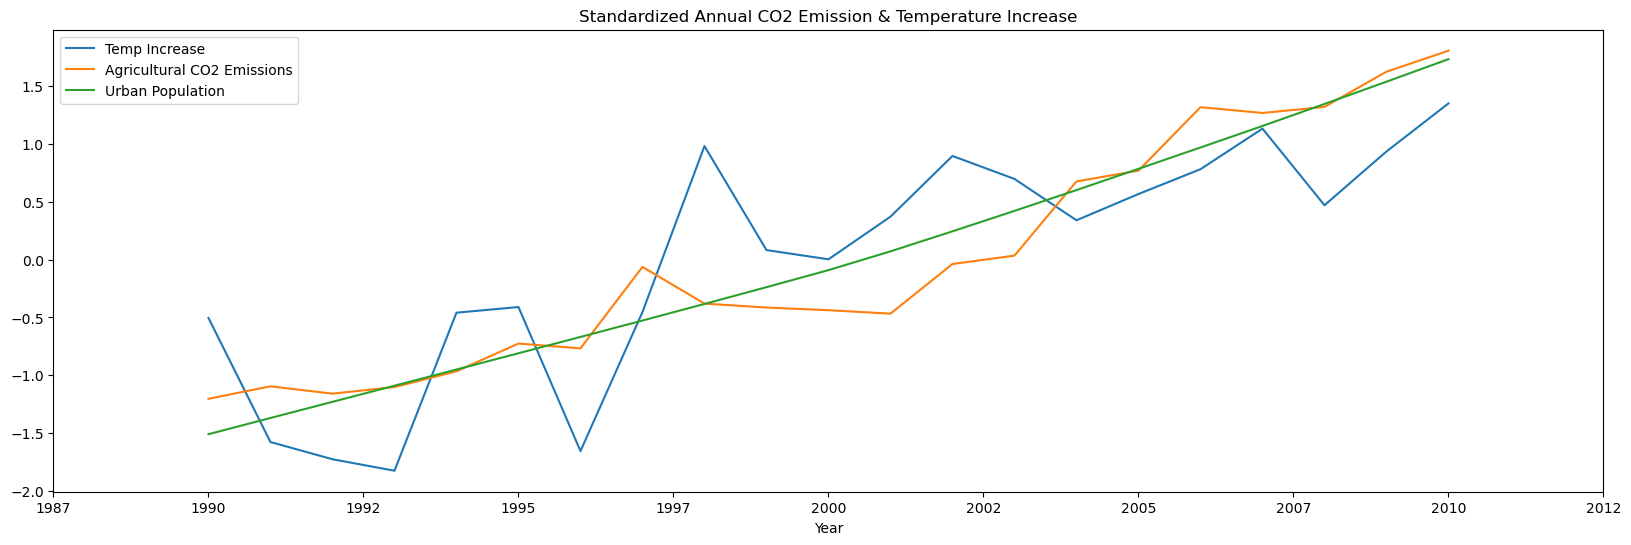

In [10]:
#Apply standard normalization to annual average temperature change, annual total global emissions, annual total urban population)
norm_ag_data_yr = standardize_df(ag_data_yr, ag_data_yr.columns)

norm_ag_data_yr.plot(figsize=(20, 6))
plt.title("Standardized Annual CO2 Emission & Temperature Increase")
plt.xlabel("Year")
plt.legend(['Temp Increase', 'Agricultural CO2 Emissions', 'Urban Population'])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0].astype(int))
plt.show()

### One Hot Encoding

In [11]:
# One hot encoding "area"
area_dummies = pd.get_dummies(
    ag_data['area'],
    drop_first = True)

# add to initial df
ag_data = pd.concat(
    [ag_data, area_dummies],
    axis=1
)

ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,0,0,0,0,0,0,0,0,0,0
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,0,0,0,0,0,0,0,0,0,0
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,0,0,0,0,0,0,0,0,0,0
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,0,0,0,0,0,0,0,0,0,0
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,0,0,0,0,0,0,0,0,0,0


In [12]:
ag_data.shape

(6965, 266)

### Sort and split data

In [13]:
#Sort values by year and reset indexing
ag_data = ag_data.sort_values(by=['year']).reset_index(drop=True)

In [14]:
ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.000000,0.0000,11.807483,63.1152,-2388.8030,...,0,0,0,0,0,0,0,0,0,0
1,Libya,1990,0.5397,0.0000,28.5588,248.061497,0.0000,83.000000,692.9556,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,Liechtenstein,1990,0.0000,0.0000,NaN,9239.011226,0.0000,11.481085,0.0001,10.7375,...,0,0,0,0,0,0,0,0,0,0
3,Madagascar,1990,2615.7130,659.3090,227.7026,5772.435200,4239.3751,3.000000,55.3162,-1457.7823,...,0,0,0,0,0,0,0,0,0,0
4,Malawi,1990,281.4975,410.4235,100.9752,56.922300,838.0748,2.000000,46.0458,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X = ag_data.drop(labels=['average_temperature_°c'], axis=1)
y = ag_data['average_temperature_°c']

In [16]:
X_train, X_val, X_test = X.iloc[:4876], X.iloc[4876:6269], X.iloc[6269:]
y_train, y_val, y_test = y.iloc[:4876], y.iloc[4876:6269], y.iloc[6269:]

In [17]:
print('X Train Shape:', X_train.shape)
print('y Train Shape:', y_train.shape)

print('X Val Shape:', X_val.shape)
print('y Val Shape:', y_val.shape)

print('X Test Shape:', X_test.shape)
print('y Test Shape:', y_test.shape)

X Train Shape: (4876, 265)
y Train Shape: (4876,)
X Val Shape: (1393, 265)
y Val Shape: (1393,)
X Test Shape: (696, 265)
y Test Shape: (696,)


In [18]:
X_train.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.000000,0.0000,11.807483,63.1152,-2388.8030,...,0,0,0,0,0,0,0,0,0,0
1,Libya,1990,0.5397,0.0000,28.5588,248.061497,0.0000,83.000000,692.9556,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,Liechtenstein,1990,0.0000,0.0000,NaN,9239.011226,0.0000,11.481085,0.0001,10.7375,...,0,0,0,0,0,0,0,0,0,0
3,Madagascar,1990,2615.7130,659.3090,227.7026,5772.435200,4239.3751,3.000000,55.3162,-1457.7823,...,0,0,0,0,0,0,0,0,0,0
4,Malawi,1990,281.4975,410.4235,100.9752,56.922300,838.0748,2.000000,46.0458,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)